# Problem Statement

An **anomaly** ( also known as **outlier**) is an observation that deviates significantly from all the other observations. An anomaly detection system is a system that detects anomalies in the data. 

Commonly used anomaly detection algorithms
- Interquartile Range
- Isolation Forest
- Median Absolute Deviation
- K-Nearest Neighbours

These are a few of the many algorithms available.

# Importing the Data

In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import IsolationForest
from pyod.models.mad import MAD
from pyod.models.knn import KNN

creating a dataframe consisting of dates and amount values

In [2]:
# dataframe values

data_values = [['2021-05-1', 45000.0],
       ['2021-05-2', 70000.0],
       ['2021-05-3', 250000.0],
       ['2021-05-4', 70000.0],
       ['2021-05-5', 45000.0],
       ['2021-05-6', 55000.0],
       ['2021-05-7', 35000.0],
       ['2021-05-8', 60000.0],
       ['2021-05-9', 45000.0],
       ['2021-05-10', 25000.0],
       ['2021-05-11', 142936.0],
       ['2021-05-12', 138026.0],
       ['2021-05-13', 28347.0],
       ['2021-05-14', 40962.66],
       ['2021-05-15', 34543.0],
       ['2021-05-16', 40962.66],
       ['2021-05-17', 25207.0],
       ['2021-05-18', 37502.0],
       ['2021-05-19', 29589.0],
       ['2021-05-20', 78404.0],
       ['2021-05-21', 26593.0],
       ['2021-05-22', 123267.0],
       ['2021-05-23', 46880.0],
       ['2021-05-24', 65361.0],
       ['2021-05-25', 46042.0],
       ['2021-05-26', 48209.0],
       ['2021-05-27', 44461.0],
       ['2021-05-28', 90866.0],
       ['2021-05-29', 46886.0],
       ['2021-05-30', 33456.0],
       ['2021-05-31', 46251.0],
       ['2021-06-1', 29370.0],
       ['2021-06-2', 165620.0],
       ['2021-06-3', 20317.0]]
       
data = pd.DataFrame(data_values , columns=['date', 'amount'])
data.head()

,date,amount
0,2021-05-1,45000.0
1,2021-05-2,70000.0
2,2021-05-3,250000.0
3,2021-05-4,70000.0
4,2021-05-5,45000.0


## Inter Quartile Range

Let's create 2 functions
1. **find_anomalies** - finds the anomalies in the data according to the thresholds provided

In [3]:
def find_anomalies(value, lower_threshold, upper_threshold):
    
    if value < lower_threshold or value > upper_threshold:
        return 1
    else: return 0

2. **iqr_anomaly_detector** 
- finds out the 25th and 75th percentile (1st and 3rd quartile)
- interquartile range is found which is the difference between the third and first quartile
- finding the upper and lower threshold above and below which the anomalies lie respectively

In [4]:
def iqr_anomaly_detector(data, column='amount', threshold=1.5):
    
    df = data.copy()
    quartiles = dict(data[column].quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1

    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)

    print(f"Lower threshold: {lower_threshold}, \nUpper threshold: {upper_threshold}\n")
    
    df['Predictions'] = data[column].apply(find_anomalies, args=(lower_threshold, upper_threshold))
    return df

In [5]:
iqr_df = iqr_anomaly_detector(data)

Lower threshold: -16617.25, 
Upper threshold: 120114.75



3. **plot_anomalies** - plotting the anomalies found

In [6]:
def plot_anomalies(df, x='date', y='amount'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

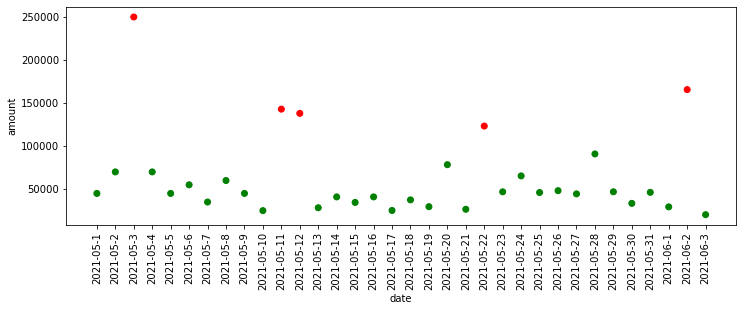

In [7]:
plot_anomalies(iqr_df)

Creating a function named **fit_model** for repeated usage
- The fit_model function takes in model and data as input, here we are finding anomalies on the amount column.
- After that, it reshapes the data into one-dimensional data and fits the provided model and predicts the anomalies in the data and stores it in the predictions column of the provided data frame, and returns it.

In [8]:
def fit_model(model, data, column='amount'):
    
    df = data.copy()
    
    data_to_predict = data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    return df

## Isolation Forest

- Isolation Forest is an algorithm that detects anomalies by taking a subset of data and constructing many isolation trees out of it.
- The core idea is that the anomalies are much easier to isolate than the normal observations and the anomalies exist in much smaller depths of an isolation tree. 
- An isolation tree is constructed by randomly selecting a feature and randomly selecting a value from that feature.
- A forest is constructed by aggregating all the isolation trees.

In [9]:
# Let's define the Isolation Forest model with 125 isolation trees, then we pass the model, data as inputs to the 
# fit_model function, where it fits the model on the data and provides predictions to us.

iso_forest = IsolationForest(n_estimators=125)
iso_df = fit_model(iso_forest, data)

In [10]:
# The isolation forest assigns -1 to the anomalous data and 1 to the normal data, so for simplicity, we convert 
# the normal data prediction (1) to 0 and anomalous data prediction(-1) to 1.

iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
iso_df.head()

,date,amount,Predictions
0,2021-05-1,45000.0,0
1,2021-05-2,70000.0,0
2,2021-05-3,250000.0,1
3,2021-05-4,70000.0,0
4,2021-05-5,45000.0,0


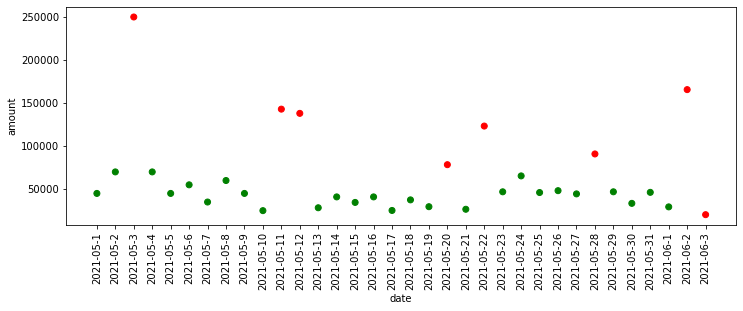

In [11]:
# plotting the anomalies predicted by Isolation Forest

plot_anomalies(iso_df)

In [12]:
univariate_data = data['amount'].to_numpy().reshape(-1, 1)

# These values range from -0.5 to 0.5
anomaly_scores = iso_forest.decision_function(univariate_data)
anomaly_scores

array([ 0.13212103,  0.03702282, -0.30699712,  0.03702282,  0.13212103,
        0.0375017 ,  0.08128305,  0.02760683,  0.13212103,  0.04104746,
       -0.07200346, -0.06338086,  0.06445796,  0.08734865,  0.0835395 ,
        0.08734865,  0.04317787,  0.06457794,  0.07527786, -0.02961929,
        0.04071521, -0.10122755,  0.12611715,  0.01934112,  0.13120275,
        0.09018621,  0.10771769, -0.07830535,  0.12611715,  0.06871164,
        0.13057327,  0.07875756, -0.16881268, -0.07952242])

In [13]:
iso_df['Anomaly Scores'] = anomaly_scores
iso_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,0.132121
1,2021-05-2,70000.0,0,0.037023
2,2021-05-3,250000.0,1,-0.306997
3,2021-05-4,70000.0,0,0.037023
4,2021-05-5,45000.0,0,0.132121


In [14]:
# Changing (-0.5, 0.5) to (0, 1)

def scale_anomaly_scores(s):
    a, b = (-0.5, 0.5), (1, 0)
    (a1, a2), (b1, b2) = a, b
    return (b1 + ((s - a1) * (b2 - b1) / (a2 - a1))) * 100

In [15]:
# Scale it between 1 and 100
scaled_scores = pd.Series(anomaly_scores).map(scale_anomaly_scores).to_numpy()

In [16]:
iso_df['Scaled Scores'] = scaled_scores
iso_df.head()

,date,amount,Predictions,Anomaly Scores,Scaled Scores
0,2021-05-1,45000.0,0,0.132121,36.787897
1,2021-05-2,70000.0,0,0.037023,46.297718
2,2021-05-3,250000.0,1,-0.306997,80.699712
3,2021-05-4,70000.0,0,0.037023,46.297718
4,2021-05-5,45000.0,0,0.132121,36.787897


# Median Absolute Deviation

- Median Absolute Deviation is the difference between each observation and the median of those observations. 
- An observation that deviates more from the rest of the observation is considered to be an anomaly.

The computation of mean is highly influenced by the outliers and a mean value would be spurious if there are outliers in data. Hence, we have choosen median.

In [17]:
# Let's define the Median Absolute Deviation model, then we pass the model, data as inputs to the fit_model function,
# where it fits the model on the data and provides predictions to us.

mad_model = MAD()
mad_df = fit_model(mad_model, data)

C:\Users\K.KALYANKUMAR\Downloads\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


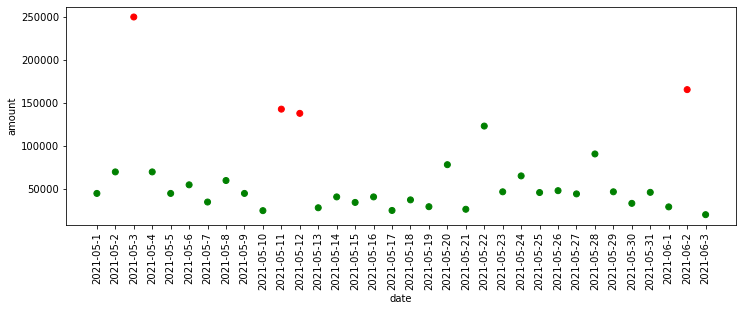

In [18]:
# plotting the anomalies predicted by MAD model.

plot_anomalies(mad_df)

In [19]:
def get_anomaly_scores(model):
    anomaly_scores = model.decision_scores_
    threshold = model.threshold_
    return anomaly_scores, threshold

In [20]:
anomaly_scores, threshold = get_anomaly_scores(mad_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [0.02311101 1.08586271 9.07047355 1.08586271 0.02311101 0.42047848
 0.4667005  0.64227322 0.02311101 0.91028999 4.32122702 4.10342458
 0.76182059 0.20220317 0.48697254 0.20220317 0.90110769 0.35571441
 0.70672678 1.45865532 0.83962619 3.44873085 0.06028381 0.88008155
 0.02311101 0.11923686 0.04702049 2.01145655 0.06054997 0.53519072
 0.03238203 0.71644139 5.32746542 1.11802295], 
Threshold: 3.5


In [21]:
mad_df['Anomaly Scores'] = anomaly_scores
mad_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,0.023111
1,2021-05-2,70000.0,0,1.085863
2,2021-05-3,250000.0,1,9.070474
3,2021-05-4,70000.0,0,1.085863
4,2021-05-5,45000.0,0,0.023111


# K-Nearest Neighbours Model

- K-Nearest Neighbours algorithm detects anomalies using the distances of k-nearest neighbors as anomaly scores. 
- The idea is that if an observation is much far from the other observations then that observation is considered to be an anomaly.

In [22]:
# Let's define the K-Nearest Neighbour model, then we pass the model with data as inputs to the fit_model function, 
# where it fits the model on the data and provides predictions to us.

knn_model = KNN()
knn_df = fit_model(knn_model, data)

C:\Users\K.KALYANKUMAR\Downloads\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


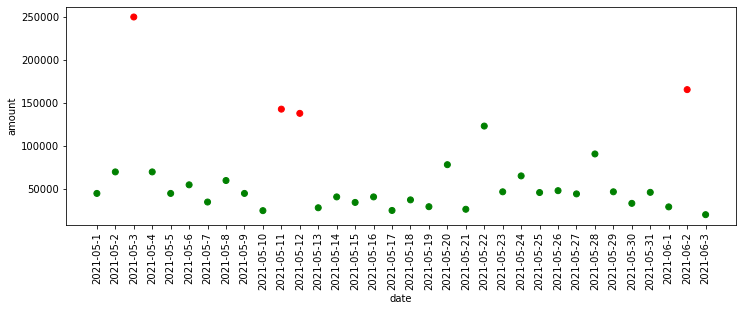

In [23]:
# plotting the anomalies predicted by the KNN model.

plot_anomalies(knn_df)

In [24]:
anomaly_scores, threshold = get_anomaly_scores(knn_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [  1251.    15000.   159134.    15000.     1251.     8749.     5630.
  11791.     1251.     4589.    64532.    59622.     3347.     4037.34
   5173.     4037.34   4382.     4046.     4382.    18404.     2996.
  44863.     1880.    13043.     1042.     3209.     1790.    30866.
   1886.     4086.     1251.     4163.    84380.     9053.  ], 
Threshold: 55194.29999999999


In [25]:
knn_df['Anomaly Scores'] = anomaly_scores
knn_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,1251.0
1,2021-05-2,70000.0,0,15000.0
2,2021-05-3,250000.0,1,159134.0
3,2021-05-4,70000.0,0,15000.0
4,2021-05-5,45000.0,0,1251.0


In [26]:
# Threshold computation
pd.Series(anomaly_scores).quantile(.90)

55194.29999999999